In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORT LIBRARIES

In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  ## to categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

## DEFINE CONSTANTS


In [26]:

FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

## PREPARE TRAINING DATA


In [27]:
filenames = os.listdir("/content/drive/MyDrive/CAT AND DOG CLASSIFIER")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [28]:
df.head()

,filename,category
0,354.jpg,0
1,338.jpg,0
2,350.jpg,0
3,362.jpg,0
4,391.jpg,0


In [29]:

df.tail()

,filename,category
807,cat.98.jpg,0
808,cat.75.jpg,0
809,cat.97.jpg,0
810,cat.93.jpg,0
811,cat.99.jpg,0


## SEE TOTAL IN COUNT

<Axes: xlabel='category'>

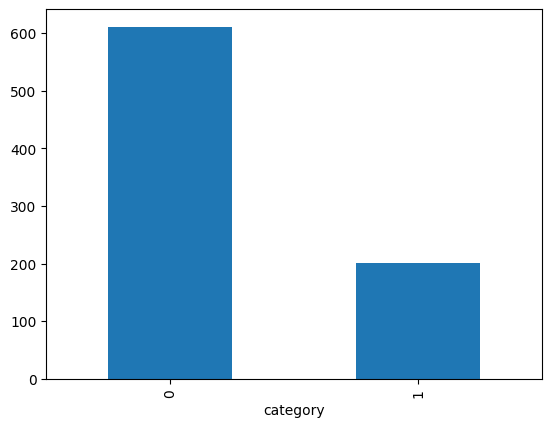

In [30]:
df['category'].value_counts().plot.bar()

## SEE SAMPLES IMAGES


In [32]:

sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/CAT AND DOG CLASSIFIER")"+sample)
plt.imshow(image)

SyntaxError: unterminated string literal (detected at line 2) (<ipython-input-32-613374a28591>, line 2)

In [33]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape= (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation ='softmax')) # 2 bcoz we have cat & dog

model.compile(loss= 'categorical_crossentropy', optimizer= 'rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 61, 61, 64)       

## CALLBACKS

In [34]:
earlystop = EarlyStopping(patience =10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

## PREPARE DATA
# Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

In [35]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [36]:

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

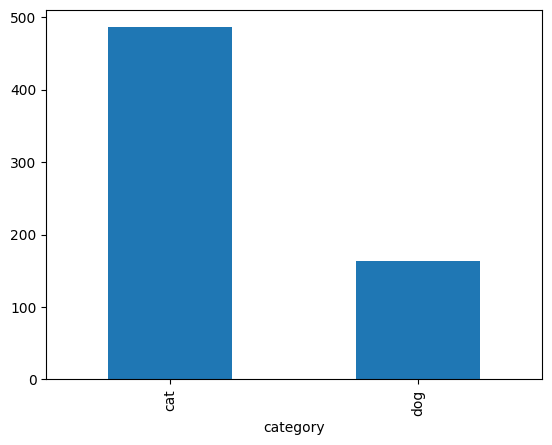

In [37]:
train_df['category'].value_counts().plot.bar()


<Axes: xlabel='category'>

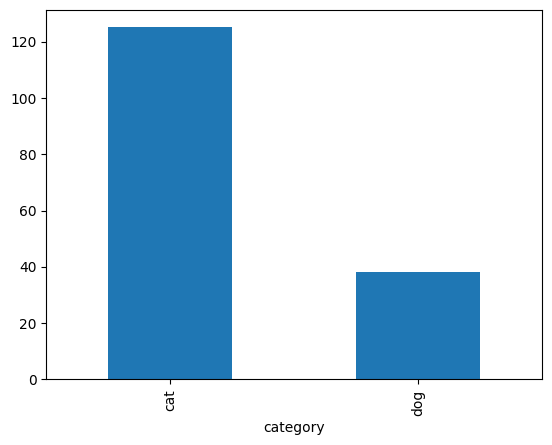

In [38]:
validate_df['category'].value_counts().plot.bar()

In [39]:

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size= 15

## TRAINING GENERATOR

In [40]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/OPENCV BASICS/CAT DOG CLASSIFIER/train/",
    x_col= 'filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size

)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 649 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


## VALIDATION GENERATOR

In [41]:

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/OPENCV BASICS/CAT DOG CLASSIFIER/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 163 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [42]:

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/OPENCV BASICS/CAT DOG CLASSIFIER/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'

)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


IndexError: index 0 is out of bounds for axis 0 with size 0

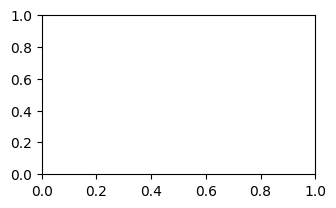

In [44]:

plt.figure(figsize=(12,12))
for i in range(0,15):
  plt.subplot(5,3, i+1)
  for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

## FIT MODEL

In [45]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

<ipython-input-45-c6b27000a4e6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


ValueError: Asked to retrieve element 0, but the Sequence has length 0

## VISUALIZE TRAINING

NameError: name 'history' is not defined

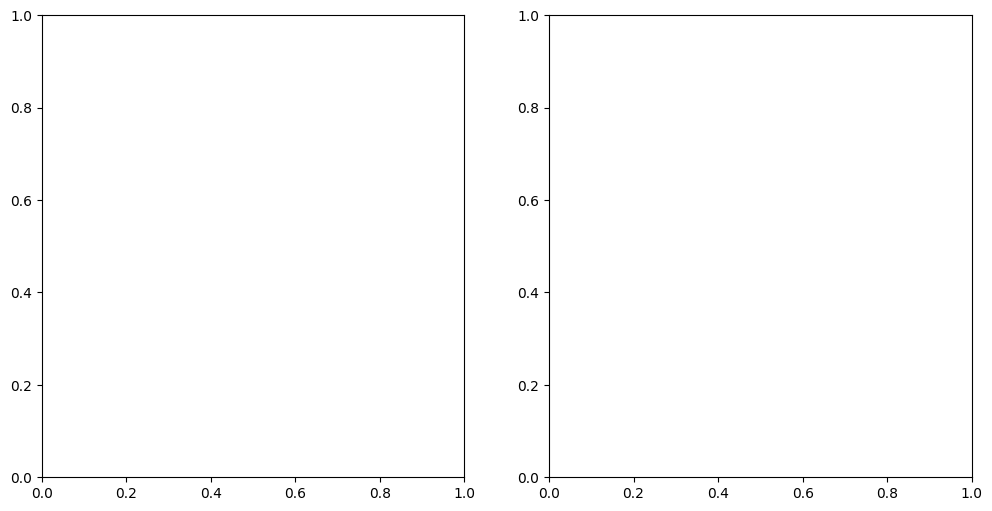

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
ax1.plot(history.history['loss'], color ='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color ='r', label="Validation Loss")
ax1.set_xticks(np.arange(1, 11, 1))
ax1.set_yticks(np.arange(0,1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, 11, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## CONFUSION MATRIX

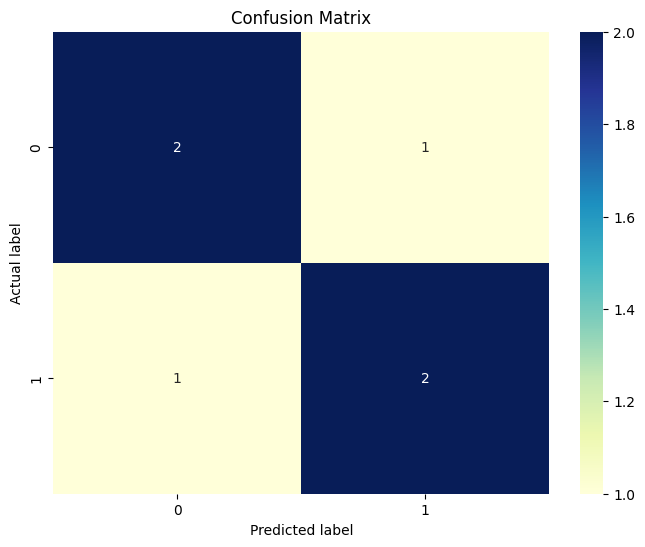

In [47]:

# Assuming you have defined y_test and y_pred earlier or from your model predictions

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some example data
y_test = [0, 1, 0, 1, 0, 1]  # Example true labels
y_pred = [0, 1, 0, 0, 1, 1]  # Example predicted labels


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## CLASSIFICATION REPORT

In [48]:
# Calculate and print the Classification Report with zero_division parameter
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



In [49]:

# prediction
result = model.predict(validation_generator,batch_size = batch_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_test = validation_generator.labels

# Evaluvate
loss,acc = model.evaluate(validation_generator, batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [51]:
from google.colab.patches import cv2_imshow
import cv2
import os
import random

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

for i in range(10):
    all_test_images = os.listdir('/content/drive/MyDrive/CAT AND DOG CLASSIFIER/test')
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'/content/drive/MyDrive/CAT AND DOG CLASSIFIER")/test/{random_image}')
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

    org = img.copy()
    img = img.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

    pred = model.predict(img)
    print(['cat', 'dog'][int(pred[0][0])])
    cv2_imshow(org)
    cv2.waitKey(0)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CAT AND DOG CLASSIFIER/test'

In [52]:
import gradio as gr
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'gradio'

In [53]:
import os
os.chdir("/content/drive/MyDrive/CAT AND DOG CLASSIFIER")")

SyntaxError: unterminated string literal (detected at line 2) (<ipython-input-53-0cdc15026bc3>, line 2)

In [21]:
!dir

drive  sample_data


In [54]:
import cv2

def predict(Image):
    img = cv2.resize(Image, (128, 128))  # Correct usage of cv2.resize
    img = img.reshape(1, 128, 128, 3)
    preds = model.predict(img)[0]
    result = dict()
    result["Cat"] = round(float(list(preds)[0]), 3)
    result["Dog"] = round(float(list(preds)[1]), 3)
    return result